# Methods and Results

In [2]:
# import the libraries used for analysis

library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
v purrr   0.3.5      
-- Conflicts ------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [31]:
order <- c("high", "low")

dataset <- read_csv('../data/forestfires.csv') %>%
  select(wind, area) %>%
  mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
  filter(!is.na(wind) | !is.na(area)) %>%
  mutate(
    category=cut(wind, breaks=quantile(wind,c(0,1/2,1)), labels=order,include.lowest = TRUE),
    area_log10 = log10(1+ area)
  )

head(dataset)

Rows: 517 Columns: 13
-- Column specification -------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area,category,area_log10
<dbl>,<dbl>,<fct>,<dbl>
6.7,0,low,0
0.9,0,high,0
1.3,0,high,0
4.0,0,high,0
1.8,0,high,0
5.4,0,low,0


# A tibble: 1 x 2
  lower_ci upper_ci
     <dbl>    <dbl>
1    -11.6     10.6


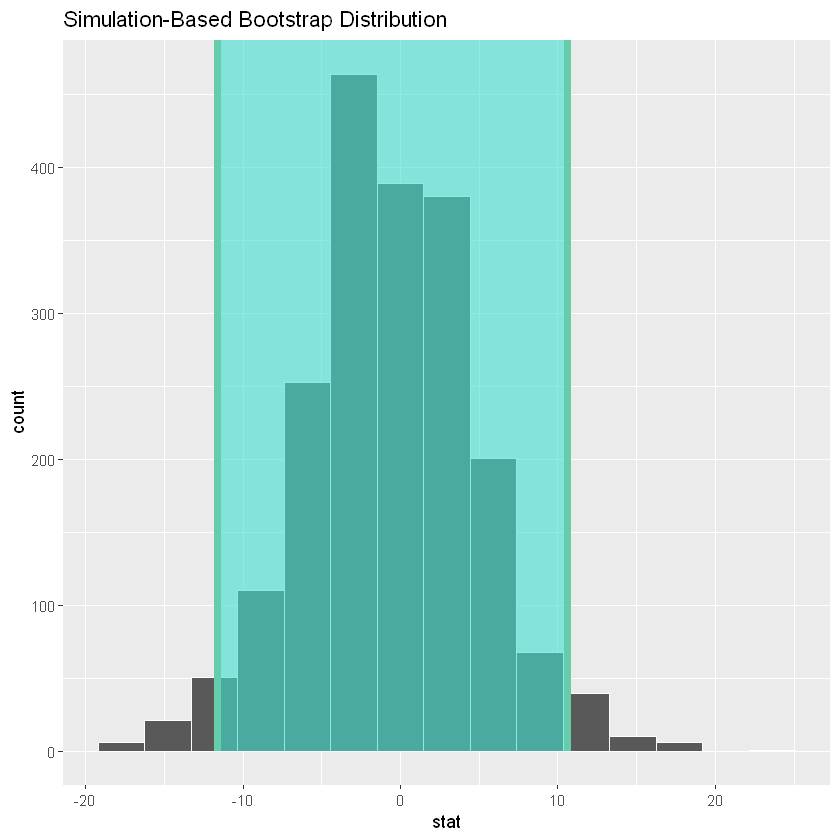

In [28]:
# set the seed so that the randomization is consistent
set.seed(1234)

# bootstrap with 2000 replicate
bootstrap_dist_data_infer <- dataset %>%
    specify(formula = area~category) %>%
	generate(type = "bootstrap", reps = 2000) %>%
	calculate(stat = "diff in means", order = order) 

percentile_ci <- bootstrap_dist_data_infer	%>%
	get_ci(type = "percentile", level = 0.95)
print(percentile_ci)

# confidence interval of the difference in means
bootstrap_dist_data_infer	%>%	visualize() +
	shade_confidence_interval(endpoints = percentile_ci)

Warning message:
"Parameter values are not specified when testing that two variables are independent."


# A tibble: 1 x 2
  lower_ci upper_ci
     <dbl>    <dbl>
1   -0.107    0.106


p_value
<dbl>
0.567


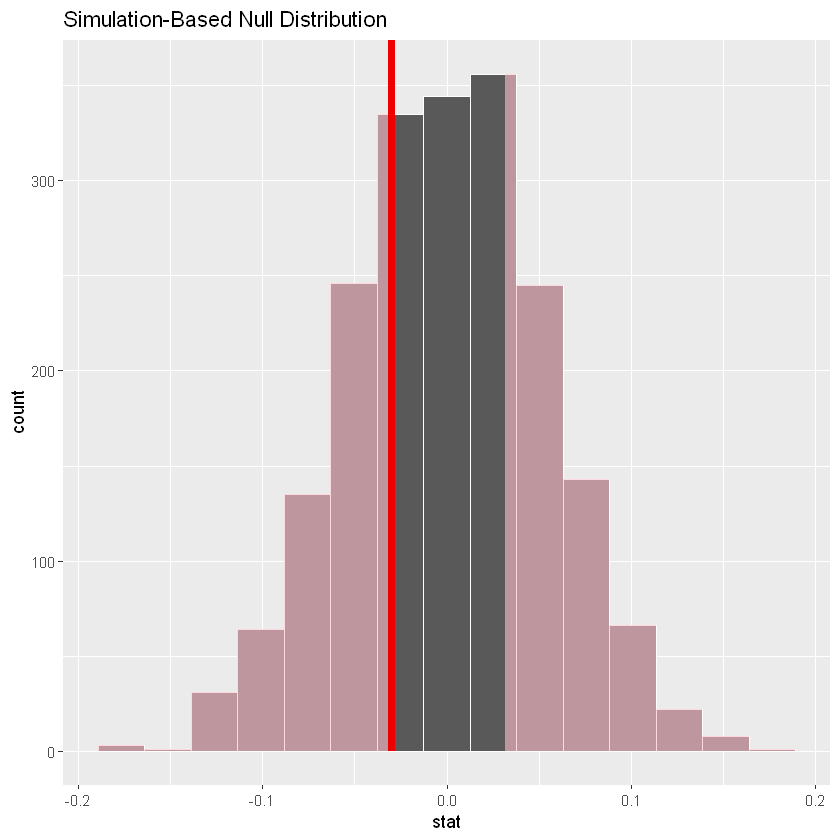

In [30]:
level <- 0.95

# null distribution (diff of means is 0) 
# of the difference in means
null_distribution_mean <- dataset %>%
  specify(formula = area_log10~category) %>% 
  hypothesize(null = "independence", mu = 0) %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(stat = "diff in means", order = order)

# the confidence interval of the null distribution
percentile_ci_null <- null_distribution_mean %>%
  get_ci(type = "percentile", level =level)

print(percentile_ci_null)

# retrieve the difference in means found in the dataset
obs_diff_means <- dataset %>% 
  specify(formula = area_log10~category) %>% 
  calculate(stat = "diff in means", order = order)

# visualize into histogram and show where the p-value lies
null_distribution_mean %>% visualize() +
    # shade_confidence_interval(endpoints = percentile_ci_null) +
    shade_p_value(obs_stat = obs_diff_means, direction = "both")

# retrieve the p-value calculated
null_distribution_mean %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")

In [62]:
# split the category
high_cat <- filter(dataset, category == 'high')
low_cat <- filter(dataset, category == 'low')

# find the variance across both categories
var1 <- var(high_cat$area_log10)
var2 <- var(low_cat$area_log10)

# count the rows
n1 <- high_cat %>% nrow()
n2 <- low_cat %>% nrow()

# find the variances between the categories
var1n1 <- (var1/n1)
var2n2 <- (var2/n2)

# find the df when the variances are very difference
df <- (var1n1/var2n2)^2 / ((1/(n1-1))*var1n1^2 + (1/(n2-1))*var2n2^2)

# calculate the t-statistic
t_stat <- (obs_diff_means) / sqrt((var1/n1) + (var2/n2))

# compare to the null distribution, find the p-value
# multiply by 2 for two-tailed test
pt(t_stat$stat, df)*2

[1] 0.5799658

In [69]:
# doing the t.test (two sample) with the t.test distribution

t.test(high_cat$area_log10, 
       low_cat$area_log10, 
       alternative = 'two.sided', 
       mu = 0, 
       paired = FALSE, 
       var.equal = FALSE) %>% tidy()

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.03014077,0.4698614,0.5000022,-0.5534347,0.5802371,455.9388,-0.1371671,0.07688552,Welch Two Sample t-test,two.sided
